<a href="https://colab.research.google.com/github/i-rybachok/RybachokMachineLearning/blob/main/%D0%9C%D0%9D_%D0%9B%D0%B0%D0%B15_%D0%A0%D0%B8%D0%B1%D0%B0%D1%87%D0%BE%D0%BA_%D0%A4%D0%86%D0%A24_8_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Рибачок Ірина, ФІТ 4-8. На парі була присутня

Лабораторна робота 5
Класифікація. Запобігання перенавчанню.
Завантажити датасет https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset?select=diabetes_prediction… Провести попередній аналіз і підготовку даних. Перевірити наявність пропущених даних, дублікатив, попарну кореляцію, кореляцію з цільовою змінною. Перевірити симетричність розподілу, балансування класів. Побудувати моделі models = { 'LogisticRegression': LogisticRegression(), 'RidgeClassifier': RidgeClassifier(), 'SGDClassifier': SGDClassifier(), 'SVC': SVC() }
Вивести класифікаційний звіт, матрицю плутанини. Підібрати оптимальні параметри HalvingGridSearchCV Вивести оптимальні параметри Вивести класифікаційний звіт Вивести 10 випадкових записів з тестової вибірки, справжній і прогнозований клас. Написати висновки.

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import PowerTransformer
from scipy.stats import zscore

import category_encoders as ce

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetes-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/diabetes-prediction-dataset


In [ ]:
df = pd.read_csv(os.path.join(path, "diabetes_prediction_dataset.csv"))
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
df.value_counts('gender')

,count
gender,
Female,58552
Male,41430
Other,18


In [ ]:
df.value_counts('smoking_history')

,count
smoking_history,
No Info,35816
never,35095
former,9352
current,9286
not current,6447
ever,4004


In [ ]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1, 'Other': 2})

df['smoking_history'] = df['smoking_history'].map({'No Info': 0,'never': 1, 'former': 2, 'current': 3, 'not current': 4,'ever': 5})

In [ ]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,1,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,1,27.32,5.7,158,0
3,0,36.0,0,0,3,23.45,5.0,155,0
4,1,76.0,1,1,3,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,0,27.32,6.2,90,0
99996,0,2.0,0,0,0,17.37,6.5,100,0
99997,1,66.0,0,0,2,27.83,5.7,155,0
99998,0,24.0,0,0,1,35.42,4.0,100,0


| Назва стовпця       | Що означає                                                      |
| ------------------- | --------------------------------------------------------------- |
| gender              | Стать людини (чоловік/жінка)                                    |
| age                 | Вік людини (у роках)                                            |
| hypertension        | Наявність гіпертензії (1 — є, 0 — немає)                        |
| heart_disease       | Наявність серцевих захворювань (1 — є, 0 — немає)               |
| smoking_history     | Історія куріння (наприклад, "never", "current", "former")       |
| bmi                 | Індекс маси тіла (Body Mass Index)                              |
| HbA1c_level         | Рівень HbA1c у крові (показник довготривалого контролю глюкози) |
| blood_glucose_level | Поточний рівень глюкози в крові                                 |
| diabetes            | Наявність діабету (1 — є, 0 — немає)                            |


In [ ]:
df.dtypes

,0
gender,int64
age,float64
hypertension,int64
heart_disease,int64
smoking_history,int64
bmi,float64
HbA1c_level,float64
blood_glucose_level,int64
diabetes,int64


In [ ]:
df["diabetes"].value_counts()

,count
diabetes,
0,91500
1,8500


In [ ]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


In [ ]:
df.duplicated().sum()

np.int64(3854)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,1,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,1,27.32,5.7,158,0
3,0,36.0,0,0,3,23.45,5.0,155,0
4,1,76.0,1,1,3,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99994,0,36.0,0,0,0,24.60,4.8,145,0
99996,0,2.0,0,0,0,17.37,6.5,100,0
99997,1,66.0,0,0,2,27.83,5.7,155,0
99998,0,24.0,0,0,1,35.42,4.0,100,0


In [ ]:
df["diabetes"].value_counts()

,count
diabetes,
0,87664
1,8482


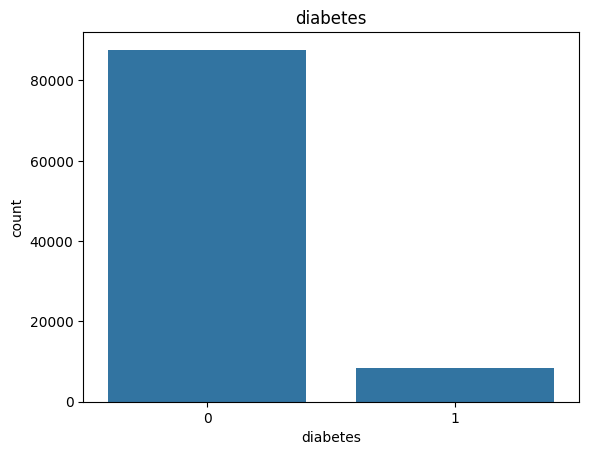

In [ ]:
sns.countplot(x='diabetes', data=df)
plt.title('diabetes')
plt.show()

In [ ]:
df.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,0.416065,41.794326,0.077601,0.040803,1.310975,27.321461,5.532609,138.218231,0.088220
std,0.493287,22.462948,0.267544,0.197833,1.409267,6.767716,1.073232,40.909771,0.283616
min,0.000000,0.080000,0.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,0.000000,43.000000,0.000000,0.000000,1.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,59.000000,0.000000,0.000000,2.000000,29.860000,6.200000,159.000000,0.000000
max,2.000000,80.000000,1.000000,1.000000,5.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
df.corrwith(df['diabetes']).sort_values(ascending=False)

,0
diabetes,1.000000
blood_glucose_level,0.424336
HbA1c_level,0.406408
age,0.264927
bmi,0.214932
hypertension,0.195710
heart_disease,0.170711
smoking_history,0.087470
gender,0.037613


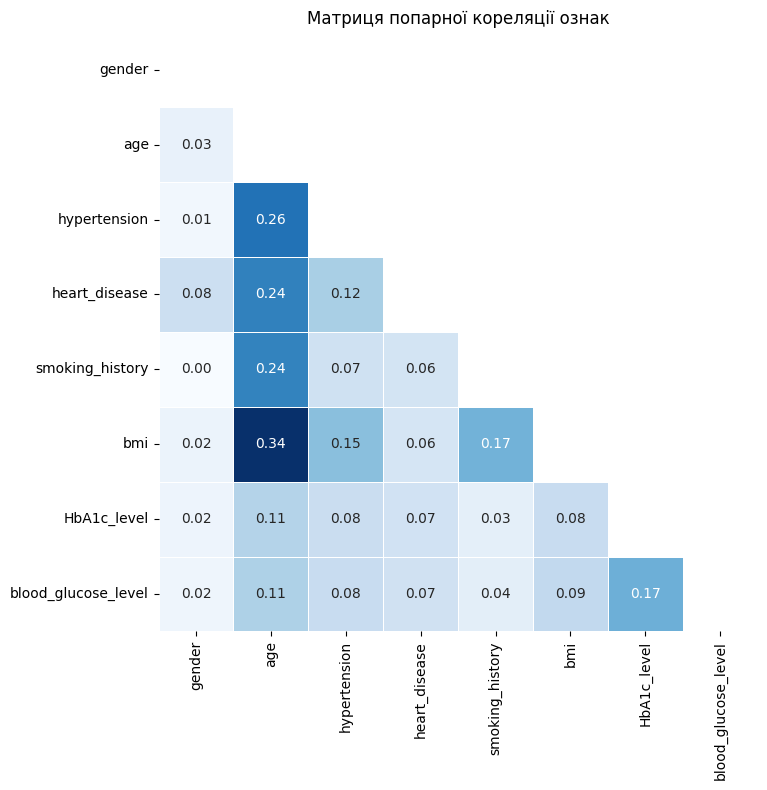

In [ ]:
mtx = df.drop('diabetes', axis=1).corr(numeric_only=True).abs()

# Побудова графіка
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    mtx,
    cmap='Blues',
    annot=True,
    fmt=".2f",
    linewidths=.5,
    mask=np.triu(np.ones_like(mtx, dtype=bool)),  # маскуємо верхню трикутну частину
    square=True,
    cbar=False,
    ax=ax
)

plt.title("Матриця попарної кореляції ознак")
plt.tight_layout()
plt.show()

Висновок: Ніяки ознаки видаляти не потрібно, оскільки немає щільної попарної кореляії

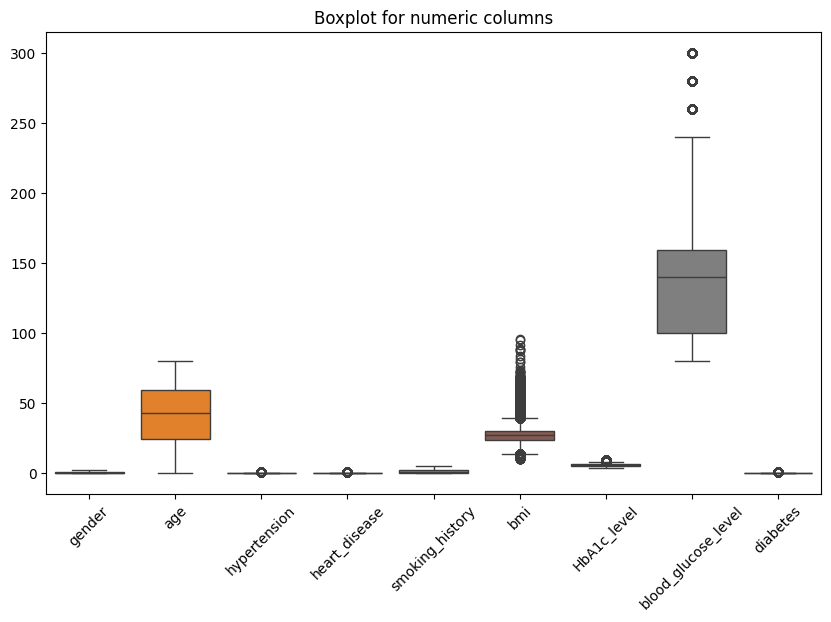

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot for numeric columns")
plt.show()

In [ ]:
df.skew(numeric_only=True)

,0
gender,0.345257
age,-0.062445
hypertension,3.157676
heart_disease,4.642359
smoking_history,1.102748
bmi,1.023751
HbA1c_level,-0.054463
blood_glucose_level,0.836489
diabetes,2.903845


Висновок: виявлено перелік ознак, у яких виявлено несеметричний розподіл

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [ ]:
X = df.drop(columns=['diabetes'], axis=1)
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train,y_train)
print(y_train.value_counts())
print(y_train_balanced.value_counts())

diabetes
0    70155
1     6761
Name: count, dtype: int64
diabetes
0    70155
1    70155
Name: count, dtype: int64


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(),
    'RidgeClassifier': RidgeClassifier(),
    'SGDClassifier': SGDClassifier(),
    'SVC': SVC()
}


=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17509
           1       0.85      0.63      0.72      1721

    accuracy                           0.96     19230
   macro avg       0.91      0.81      0.85     19230
weighted avg       0.95      0.96      0.95     19230



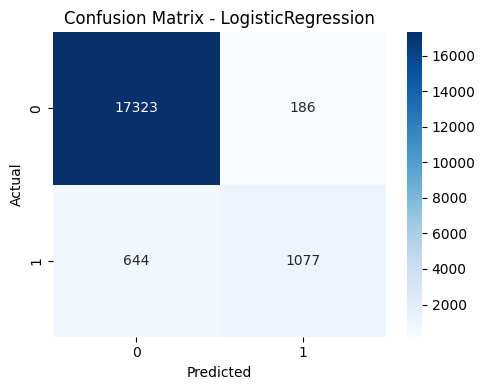


=== RidgeClassifier ===
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     17509
           1       0.99      0.30      0.46      1721

    accuracy                           0.94     19230
   macro avg       0.96      0.65      0.72     19230
weighted avg       0.94      0.94      0.92     19230



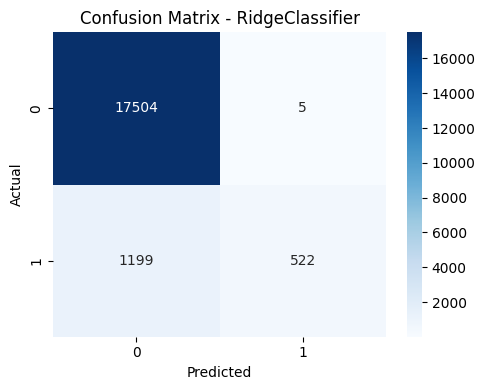


=== SGDClassifier ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17509
           1       0.84      0.60      0.70      1721

    accuracy                           0.95     19230
   macro avg       0.90      0.80      0.84     19230
weighted avg       0.95      0.95      0.95     19230



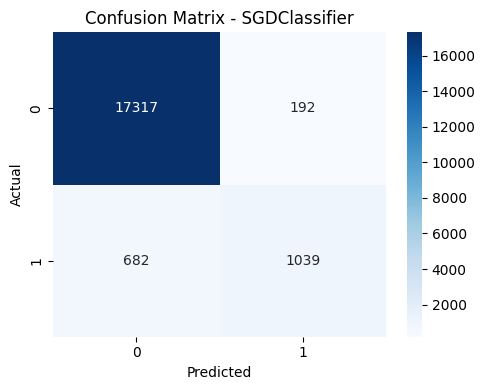


=== SVC ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17509
           1       0.97      0.58      0.73      1721

    accuracy                           0.96     19230
   macro avg       0.97      0.79      0.85     19230
weighted avg       0.96      0.96      0.96     19230



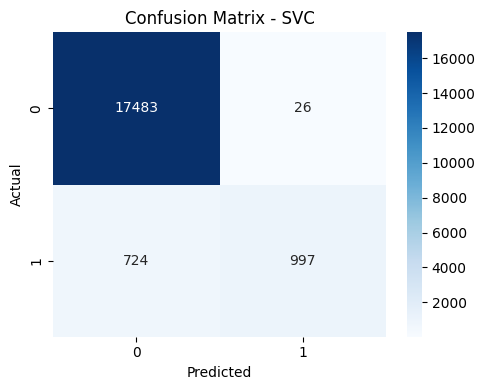

In [ ]:
# Тренуємо, оцінюємо й виводимо звіти
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    print(f"\n=== {name} ===")
    print(classification_report(y_test, predictions))

    # Матриця плутанини
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [ ]:
param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    },
    'RidgeClassifier': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'SGDClassifier': {
        'loss': ['log_loss', 'hinge'],
        'alpha': [0.0001, 0.001, 0.01],
        'penalty': ['l2', 'l1']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

In [ ]:
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
best_models = {}

# Перебір моделей
for name, model in models.items():
    print(f"\n Підбір параметрів для {name}...")

    search = HalvingGridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='accuracy',
        cv=3,
        factor=2,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    best_models[name] = best_model

    print(f" Найкращі параметри: {search.best_params_}")

    # Оцінка
    y_pred = best_model.predict(X_test)
    print("Класифікаційний звіт:")
    print(classification_report(y_test, y_pred))


 Підбір параметрів для LogisticRegression...
 Найкращі параметри: {'C': 0.1, 'solver': 'liblinear'}
Класифікаційний звіт:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17509
           1       0.86      0.62      0.72      1721

    accuracy                           0.96     19230
   macro avg       0.91      0.81      0.85     19230
weighted avg       0.95      0.96      0.95     19230


 Підбір параметрів для RidgeClassifier...
 Найкращі параметри: {'alpha': 1.0}
Класифікаційний звіт:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     17509
           1       0.99      0.30      0.46      1721

    accuracy                           0.94     19230
   macro avg       0.96      0.65      0.72     19230
weighted avg       0.94      0.94      0.92     19230


 Підбір параметрів для SGDClassifier...
 Найкращі параметри: {'alpha': 0.001, 'loss': 'log_loss', 'penalty': 'l1'}
Класиф

In [ ]:
best_svc = best_models['SVC']

In [ ]:
# Вибір 10 випадкових індексів
random_indices = np.random.choice(X_test.shape[0], 20, replace=False)

# Отримання прогнозованих значень від найкращої моделі SVC
y_pred_best_svc = best_svc.predict(X_test)

# Порівняння справжніх і прогнозованих значень для вибраних випадкових індексів
random_results_df = pd.DataFrame({
    'Index': random_indices,
    'True Values': y_test.iloc[random_indices].values,  # Справжні значення
    'Predicted Values': y_pred_best_svc[random_indices]  # Прогнозовані значення
})

random_results_df

,Index,True Values,Predicted Values
0,4708,0,0
1,13228,0,0
2,2783,0,0
3,4977,0,0
4,9081,1,0
5,13401,0,0
6,10210,0,0
7,11691,0,0
8,1797,0,0
9,9159,0,0


Висновки: підготували дані, побудували матрицю кореляції, масштабували ознаки, побудували ряд моделей